In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from random import random
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data exploration

In [74]:
df = pd.read_csv("./datasets/chinesemnist/chinese_mnist.csv")
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [75]:
paths = glob("./datasets/chinesemnist/data/data/*.jpg")
# Shuffle paths
paths = np.random.permutation(paths)
# Split into train, validation, and test with 80%, 10%, 10% split
train_paths = paths[:int(len(paths)*0.8)]
val_paths = paths[int(len(paths)*0.8):int(len(paths)*0.9)]
test_paths = paths[int(len(paths)*0.9):]
print(len(train_paths), len(val_paths), len(test_paths))

12000 1500 1500


In [76]:
def load_images(paths):
    images = []
    ids = []
    for path in paths:
        char_idx = int(path.split("_")[-1][:-4])
        images.append(plt.imread(path))
        ids.append(char_idx)
    return np.array(images), ids

train_images, train_ids = load_images(train_paths)
val_images, val_ids = load_images(val_paths)
test_images, test_ids = load_images(test_paths)
print(train_images.shape, val_images.shape, test_images.shape)

(12000, 64, 64) (1500, 64, 64) (1500, 64, 64)


Now we have a dataset 
$$
(X_{i...N_{train/test/val}}, Y_{i...N_{train/test/val}})
$$ 
Where $X_{train_i} \in \mathbb{R^{64 \times 64}}$ is a train image example of dimensions 64 by 64 pixels. and $Y_i \in \mathbb{Z}$ represents the character index 

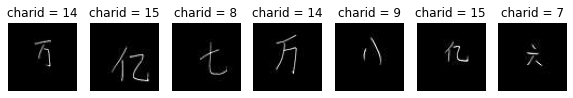

In [77]:
nsamples = 7
for i in range(nsamples):
    plt.subplot(1, nsamples, i+1).imshow(train_images[i], cmap="gray")
    plt.subplot(1, nsamples, i+1).set_title(f"charid = {train_ids[i]}")
    plt.axis("off")
plt.gcf().set_size_inches(10, 10)
plt.show()

We want to match the images head to head in a fully connected manner such that the new dataset will be pairs of images and a similarity score.
$$
(X^l_{i...N_{train/test/val} \times N_{train/test/val}}, X^r_{i...N_{train/test/val} \times N_{train/test/val}}, Y_{i...N_{train/test/val} \times N_{train/test/val}})
$$
Where $X^l_{train_i} \in \mathbb{R^{64 \times 64}}$ is a the left image example of dimensions 64 by 64 pixels. and $Y_i \in [0..1] \subset \mathbb{R}$ represents the similarity score

In [78]:
def indices2similarities(X, Y):
    N = len(X)
    D = []
    for i in range(N):
        for j in range(N):
            left = X[i]
            right = X[j]
            score = 1.0 if Y[i] == Y[j] else 0.0
            D.append((left, right, score))
    return D

def get_sim_example(X, Y, i):
    N = len(X)**2
    if i >= N:
        raise ValueError("i must be less than len(X)**2")
    row = i // N
    col = i % len(X)
    left = X[row]
    right = X[col]
    score = 1.0 if Y[row] == Y[col] else 0.0
    return left, right, score
    
def plot_sample(left, right, score):
    plt.subplot(1, 2, 1).imshow(left, cmap="gray")
    plt.subplot(1, 2, 2).imshow(right, cmap="gray")
    plt.title(f"match={score==1}, sample={i}")
    plt.axis("off")

def plot_example_i(X, Y, i):
    left, right, score = get_sim_example(X, Y, i)
    plot_sample(left, right, score)

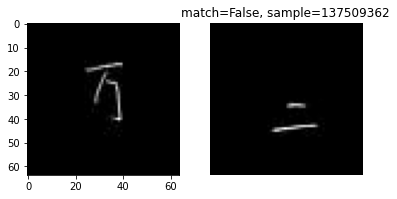

In [79]:
# Get random sample
i = np.random.randint(0, len(train_images)**2)
plot_example_i(train_images, train_ids, i)

**Potential problem**: Since there are $N \times N$ examples, assuming that image $X_i$ matches with $m$ other samples, then there are $N*m$ matching examples, therefore, the portion of matching examples in the dataset is 
$$
portion = \frac{N\cdot m}{N \times N} = \frac{m}{N}
$$
Therefore, you can already see that the portion becomes smaller in an exponential decay maner as $N$ grows, which can create a considerable data imbalance.

### Creating the datasets
Now that we have defined our dataset, we can create a PyTorch dataset that will be used for the later stages of training.

In [80]:
class ChineseMNISTDataset(Dataset):

    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)**2
    
    def __getitem__(self, index):
        N = len(self)
        if i >= N:
            raise ValueError("i must be less than len(X)**2")
        row = i // N
        col = i % len(self.X)
        left = self.X[row]
        right = self.X[col]
        left = self.__process_raw_image(left)
        right = self.__process_raw_image(right)
        score = 1.0 if self.Y[row] == self.Y[col] else 0.0

        if self.transform:
            left = self.transform(left)
            right = self.transform(right)
        return left, right, score

    def __process_raw_image(self, x):
        # Add a channel
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x /= 255.0
        return x

In [81]:
train_ds = ChineseMNISTDataset(train_images, train_ids)
val_ds = ChineseMNISTDataset(val_images, val_ids)
test_ds = ChineseMNISTDataset(test_images, test_ids)

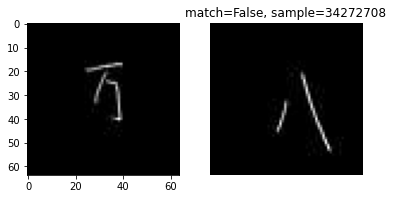

In [82]:
# Get random sample
i = np.random.randint(0, len(train_ds))
left, right, score = train_ds[i]
plot_sample(left[0], right[0], score)

## Modelling

In [89]:
from model import SiameseNetwork
from losses import ContrastiveLoss
from torch.nn import CosineEmbeddingLoss

model = SiameseNetwork().to(device)
criterion = CosineEmbeddingLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"

'28875072 trainable parameters'

In [98]:
N = 100
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=True)

In [99]:
val_losses = []
for epoch in range(N):
    model.train()
    running_epoch_loss = 0.0

    for i, (left, right, score) in enumerate(train_loader):
        
        left = left.to(device)
        right = right.to(device)
        score = score.to(device)

        optimizer.zero_grad()
        out0, out1 = model(left, right)
        loss = criterion(out0, out1, 2*score-1)
        running_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Epoch complete
    print(f"Epoch {epoch}, batch {i}, batch_loss {running_epoch_loss/10:.3f}")
    running_epoch_loss = 0.0
    
      



KeyboardInterrupt: 